# Nifty50 Analysis

## Import the Packages, Functions and Data

In [1]:
import pandas as pd
from Baseline_functions import capital_calculation
from DQN_functions import create_states, ReplayMemory, DQNAgent,train_agent,evaluate_agent, ConvDQN,plot_training,create_action_episode_df, plot_dual_axis
import torch
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim

In [29]:
import torch.nn.functional as F

In [2]:
df = pd.read_csv('data/nifty50.csv')
df.reset_index(drop=True, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.ffill()

## Outlier Removal 


In [3]:
df['daily_return'] = df['Close'].pct_change()
df['daily_return'] = df['daily_return'].fillna(0)
#mean plus 3sigma value for absolute daily returns
mean = df['daily_return'].mean()
std = df['daily_return'].std()
upper_limit = mean + 2*std
lower_limit = mean - 2*std
print(f'Mean: {mean}, Std: {std}, Upper Limit: {upper_limit}, Lower Limit: {lower_limit}')
#number of rows that are outside the 3 sigma range
print(f'Number of rows outside 2 sigma range: {len(df[(df["daily_return"]>upper_limit) | (df["daily_return"]<lower_limit)])}')
print(f'Percentage of rows outside 2 sigma range: {len(df[(df["daily_return"]>upper_limit) | (df["daily_return"]<lower_limit)])/len(df)*100}% ')

#if daily return is outside 3 sigma range, replace all the values with previous day's values
for i in range(1,len(df)):
    if df['daily_return'][i]>upper_limit or df['daily_return'][i]<lower_limit:
        df['Close'][i] = df['Close'][i-1]
        df['Open'][i] = df['Open'][i-1]
        df['High'][i] = df['High'][i-1]
        df['Low'][i] = df['Low'][i-1]
        df['Volume'][i] = df['Volume'][i-1]
        df['daily_return'][i] = 'NaN'

Mean: 0.0005418251452384599, Std: 0.010398129961910068, Upper Limit: 0.021338085069058595, Lower Limit: -0.020254434778581677
Number of rows outside 2 sigma range: 97
Percentage of rows outside 2 sigma range: 3.936688311688312% 


## DQN

### Training

In [4]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim)
        c0 = torch.zeros(num_layers, x.size(0), hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class ConvLSTMModel(nn.Module):
    def __init__(self, input_dim, output_dim, window_size, hidden_dim, num_layers):
        super(ConvLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.lstm = nn.LSTM(32, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, num_features, window_size)
        x = F.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # (batch_size, window_size, num_features)
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim)
        c0 = torch.zeros(num_layers, x.size(0), hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


class GRUWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUWithAttention, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attn_fc = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim)
        out, _ = self.gru(x, h0)
        attn_weights = F.softmax(self.attn_fc(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

class ConvGRUModel(nn.Module):
    def __init__(self, input_dim, output_dim, window_size, hidden_dim, num_layers):
        super(ConvGRUModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.gru = nn.GRU(32, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, num_features, window_size)
        x = F.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # (batch_size, window_size, num_features)
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, nhead, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model=input_dim, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers, dim_feedforward=dim_feedforward)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # (window_size, batch_size, input_dim)
        transformer_out = self.transformer(x, x)
        out = self.fc(transformer_out[-1])
        return out


In [5]:
df_base = df[['Open','High','Low','Close','Volume']]
#include 26 and 12 ema
df_base['26ema'] = df_base['Close'].ewm(span=26).mean()
df_base['12ema'] = df_base['Close'].ewm(span=12).mean()
#fill na as 0
df_base = df_base.dropna()
df_base = df_base[['Open','High','Low','Close','Volume','26ema','12ema']]

#first 80% of the data is train
df_train = df_base.iloc[:int(len(df_base)*0.8)]
#last 20% of the data is test
df_test = df_base.iloc[int(len(df_base)*0.8):]

In [6]:
display(df_train.head())

display(df_test.head())

,Open,High,Low,Close,Volume,26ema,12ema
Date,,,,,,,
2014-04-01,6729.500000,6732.250000,6675.450195,6721.049805,177800.0,6721.049805,6721.049805
2014-04-02,6757.600098,6763.500000,6723.600098,6752.549805,173300.0,6737.405574,6738.112305
2014-04-03,6772.049805,6776.750000,6696.899902,6736.100098,197500.0,6736.936529,6737.326940
2014-04-04,6741.850098,6741.850098,6685.149902,6694.350098,155100.0,6725.031224,6723.760831
2014-04-07,6694.250000,6725.149902,6650.399902,6695.049805,133900.0,6718.078409,6715.960148


,Open,High,Low,Close,Volume,26ema,12ema
Date,,,,,,,
2022-03-31,17519.199219,17559.800781,17435.199219,17464.750000,281100.0,17107.043908,17207.191859
2022-04-01,17436.900391,17703.699219,17422.699219,17670.449219,291800.0,17148.777635,17278.462222
2022-04-04,17436.900391,17703.699219,17422.699219,17670.449219,291800.0,17187.419974,17338.767914
2022-04-05,18080.599609,18095.449219,17921.550781,17957.400391,283500.0,17244.455561,17433.942141
2022-04-06,17842.750000,17901.000000,17779.849609,17807.650391,328800.0,17286.173696,17491.435718


In [7]:
print(df_train.shape, df_test.shape)
print(df_train.shape[0] + df_test.shape[0])
print(df.shape[0])

(1971, 7) (493, 7)
2464
2464


In [15]:
window_size = 26
states = create_states(df_train, window_size)
test_states = create_states(df_test, window_size)
input_dim_conv = states.shape[2]
nhead = 1
dim_feedforward = 64
hidden_dim = 32
num_layers = 2
output_dim = 3
print("Shape of states:", states.shape)

Shape of states: (1945, 26, 7)


In [12]:
input_dim_conv

7

In [16]:
model = ConvDQN(input_dim_conv, output_dim, window_size)
model1 = RNNModel(input_dim_conv, hidden_dim, output_dim, num_layers)
model2 = GRUModel(input_dim_conv, hidden_dim, output_dim, num_layers)
model3 = LSTMModel(input_dim_conv, hidden_dim, output_dim, num_layers)
model4 = ConvLSTMModel(input_dim_conv, output_dim, window_size, hidden_dim, num_layers)
model5 = GRUWithAttention(input_dim_conv, hidden_dim, output_dim, num_layers)
model6 = ConvGRUModel(input_dim_conv, output_dim, window_size, hidden_dim, num_layers)
model7 = TransformerModel(input_dim_conv, output_dim, nhead, num_layers, dim_feedforward)

memory = ReplayMemory(50000)
agent = DQNAgent(input_dim_conv, output_dim, window_size,model1, lr=0.0001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995)

Episode 1/200, Total Reward: -107.89843799999653, Loss: 10.783490023662536
Episode 2/200, Total Reward: -50.92036496100057, Loss: 10.654328593836519
Episode 3/200, Total Reward: -3.3953489938382857, Loss: 9.533890610853252
Episode 4/200, Total Reward: -40.427931330244455, Loss: 9.40502657672377
Episode 5/200, Total Reward: -8.680450827903892e-14, Loss: 9.646181605992878
Episode 6/200, Total Reward: 8.523156473727956e-07, Loss: 8.91057833803348
Episode 7/200, Total Reward: 0.006143411493966484, Loss: 8.715189352916465
Episode 8/200, Total Reward: 0.006143411493966484, Loss: 7.201207931526918
Episode 9/200, Total Reward: -0.28672219803743476, Loss: 8.67611783717704
Episode 10/200, Total Reward: -0.004472821226881342, Loss: 7.813655891904263
Episode 11/200, Total Reward: -221.7772110995706, Loss: 7.46597276832502
Episode 12/200, Total Reward: 0.006611655791495302, Loss: 10.28284347389729
Episode 13/200, Total Reward: 10.894101963223878, Loss: 7.119857927446596
Episode 14/200, Total Reward

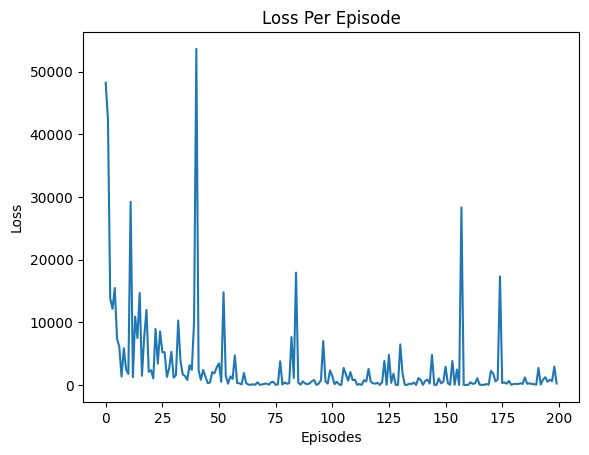

CPU times: user 3h 10min 54s, sys: 12min 45s, total: 3h 23min 39s
Wall time: 54min 16s


In [17]:
%%time
log_train = train_agent(agent, states, 200, batch_size=32)

In [18]:
log_train.to_csv('NIFTY50/log_train_RNN_200ep.csv', index=False)
log_train.head()

,Episode,Time,Reward,Action,Price,Loss
0,1,1,0.00,Hold,6659.850098,48218.113281
1,1,2,0.00,Hold,7108.750000,48218.113281
2,1,3,0.00,Buy,7108.750000,48218.113281
3,1,4,0.00,Hold,7123.149902,48218.113281
4,1,5,94.25,Sell,7203.000000,48218.113281


Episode 1/200, Total Reward: -23.650390999999217, Loss: 10.167941878897926
Episode 2/200, Total Reward: -110.09690507887804, Loss: 9.589627526639966
Episode 3/200, Total Reward: -19.993798395957235, Loss: 9.117203132360787
Episode 4/200, Total Reward: 0.7956772598168063, Loss: 9.111035269960613
Episode 5/200, Total Reward: 0.00016468452450588142, Loss: 9.37114589595616
Episode 6/200, Total Reward: 0.00047417126510986316, Loss: 8.822550313528467
Episode 7/200, Total Reward: 2.1324276365110114e-07, Loss: 7.584923607261939
Episode 8/200, Total Reward: -18.129786130415557, Loss: 9.131738000218595
Episode 9/200, Total Reward: 1.7321995329527934e-08, Loss: 10.770829771766893
Episode 10/200, Total Reward: 1.7300446733947644e-07, Loss: 10.405434620502197
Episode 11/200, Total Reward: 0.0008223737280464097, Loss: 8.502857328472054
Episode 12/200, Total Reward: 7.55420941583125e-09, Loss: 8.008648736591276
Episode 13/200, Total Reward: 2.1548211837676607, Loss: 6.844137557736529
Episode 14/200, 

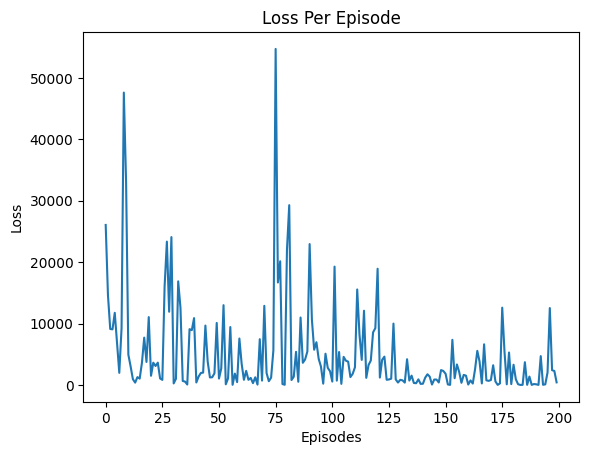

In [19]:
agent = DQNAgent(input_dim_conv, output_dim, window_size,model2, lr=0.0001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995)
log_train = train_agent(agent, states, 200, batch_size=32)
log_train.to_csv('NIFTY50/log_train_GRU_200ep.csv', index=False)

Episode 1/200, Total Reward: -50.92036496100057, Loss: 9.735849730414921
Episode 2/200, Total Reward: -8.176114503656473, Loss: 11.09385862282087
Episode 3/200, Total Reward: -0.47254951991480154, Loss: 11.103661156845064
Episode 4/200, Total Reward: -5.8453437037051375, Loss: 9.636414690705703
Episode 5/200, Total Reward: 1.1075672861401212e-06, Loss: 9.168448062034134
Episode 6/200, Total Reward: -2.002982228503967, Loss: 9.9834980481524
Episode 7/200, Total Reward: 4.4889701699375335e-11, Loss: 11.776757521895446
Episode 8/200, Total Reward: 0.008932149926252015, Loss: 8.308253281776802
Episode 9/200, Total Reward: -0.00015179413405450766, Loss: 10.877437115555326
Episode 10/200, Total Reward: 6.525745078035948e-11, Loss: 10.006824733569806
Episode 11/200, Total Reward: 4.153088760524892e-17, Loss: 9.163854172733794
Episode 12/200, Total Reward: 0.0, Loss: 9.60266654629614
Episode 13/200, Total Reward: -1.1327223569457924e-16, Loss: 9.66720978393512
Episode 14/200, Total Reward: 10.

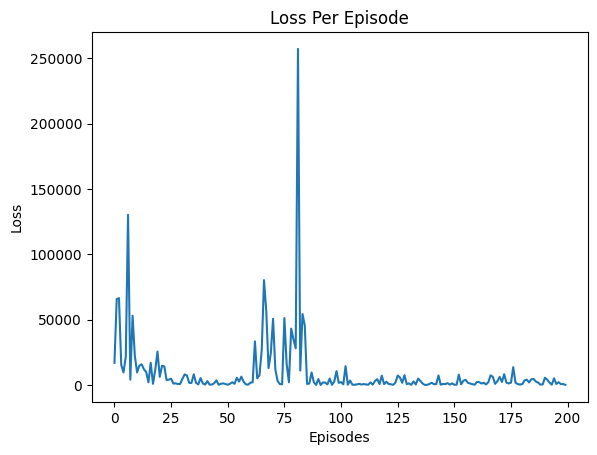

In [20]:
agent = DQNAgent(input_dim_conv, output_dim, window_size,model3, lr=0.0001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995)
log_train = train_agent(agent, states, 200, batch_size=32)
log_train.to_csv('NIFTY50/log_train_LSTM_200ep.csv', index=False)


Episode 1/200, Total Reward: 29.31464868832123, Loss: 9.807895682670258
Episode 2/200, Total Reward: -8.017252126087156, Loss: 10.42075523318665
Episode 3/200, Total Reward: -128.21430315582597, Loss: 9.454544643659414
Episode 4/200, Total Reward: 10.042460902191685, Loss: 10.020655121053684
Episode 5/200, Total Reward: 34.83646995115633, Loss: 9.366107963762543
Episode 6/200, Total Reward: 0.00211021670501434, Loss: 9.084415135317107
Episode 7/200, Total Reward: 0.0, Loss: 8.530230105969133
Episode 8/200, Total Reward: -0.040223630377869045, Loss: 7.306635931542057
Episode 9/200, Total Reward: -1.2209401860032887, Loss: 7.090848632590855
Episode 10/200, Total Reward: 502.2896481000007, Loss: 9.164125239175272
Episode 11/200, Total Reward: 1.1401121037415507e-06, Loss: 8.869409420982395
Episode 12/200, Total Reward: 9.429181388408082, Loss: 7.5988184413393585
Episode 13/200, Total Reward: -60.11035848797346, Loss: 8.376885094066223
Episode 14/200, Total Reward: -0.014035608325789779, L

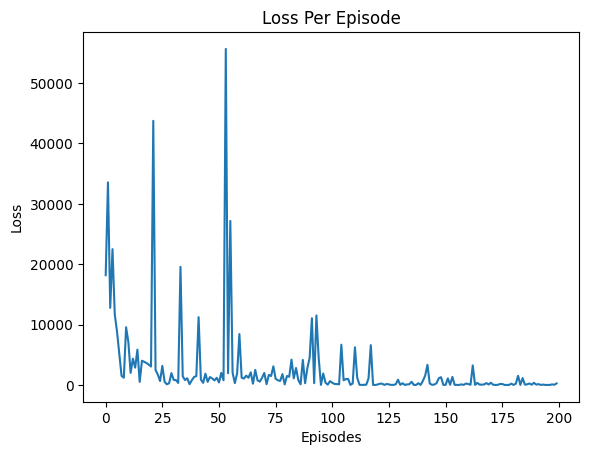

In [33]:
agent = DQNAgent(input_dim_conv, output_dim, window_size,model4, lr=0.0001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995)
log_train = train_agent(agent, states, 200, batch_size=32)
log_train.to_csv('NIFTY50/log_train_ConvLSTM_200ep.csv', index=False)

Episode 1/200, Total Reward: 332.6561167988525, Loss: 10.167919539569981
Episode 2/200, Total Reward: 29.77805731164219, Loss: 9.87061281725401
Episode 3/200, Total Reward: -28.722863000220624, Loss: 10.417843149546595
Episode 4/200, Total Reward: 11.515561276343673, Loss: 9.472666174165548
Episode 5/200, Total Reward: 7.992514481380537e-05, Loss: 9.254722397061066
Episode 6/200, Total Reward: 0.0, Loss: 9.179809782272432
Episode 7/200, Total Reward: -58.945719605612304, Loss: 9.482690964840089
Episode 8/200, Total Reward: -6.432647421079819e-05, Loss: 8.513027005371521
Episode 9/200, Total Reward: -81.09279601462875, Loss: 9.375959247531794
Episode 10/200, Total Reward: 0.006852840912997586, Loss: 8.34530456095059
Episode 11/200, Total Reward: 1.4386238845157185e-06, Loss: 9.097675357016287
Episode 12/200, Total Reward: -2.7801330183315304e-06, Loss: 6.404129120283416
Episode 13/200, Total Reward: 3.209877233853917e-05, Loss: 8.923925920232849
Episode 14/200, Total Reward: 2.633396528

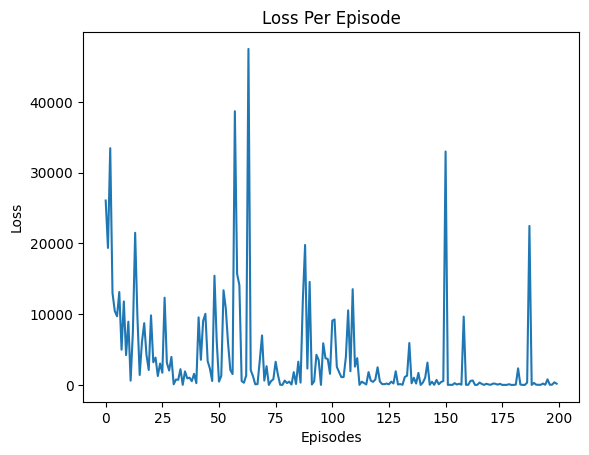

In [34]:
agent = DQNAgent(input_dim_conv, output_dim, window_size,model5, lr=0.0001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995)
log_train = train_agent(agent, states, 200, batch_size=32)
log_train.to_csv('NIFTY50/log_train_GRUWithAttention_200ep.csv', index=False)

Episode 1/200, Total Reward: 879.6603518999993, Loss: 9.11273981735855
Episode 2/200, Total Reward: 374.3496099999975, Loss: 10.473817612120895
Episode 3/200, Total Reward: 18.665532585898863, Loss: 10.78579580273572
Episode 4/200, Total Reward: -100.0592225542806, Loss: 9.946929829864994
Episode 5/200, Total Reward: -54.82153001939391, Loss: 9.923530461930389
Episode 6/200, Total Reward: -100.0592225542806, Loss: 9.95763425255578
Episode 7/200, Total Reward: -0.6064513175660664, Loss: 9.186158537119777
Episode 8/200, Total Reward: -0.016951659898039262, Loss: 9.008132982080792
Episode 9/200, Total Reward: 0.0, Loss: 9.501312606956937
Episode 10/200, Total Reward: 7.76550191419355e-06, Loss: 11.862905390958106
Episode 11/200, Total Reward: 7.76550191419355e-06, Loss: 9.385145141607556
Episode 12/200, Total Reward: 804.9249228060011, Loss: 9.055882043918603
Episode 13/200, Total Reward: 0.5320441463103479, Loss: 8.619556299410823
Episode 14/200, Total Reward: 619.548827999999, Loss: 10.

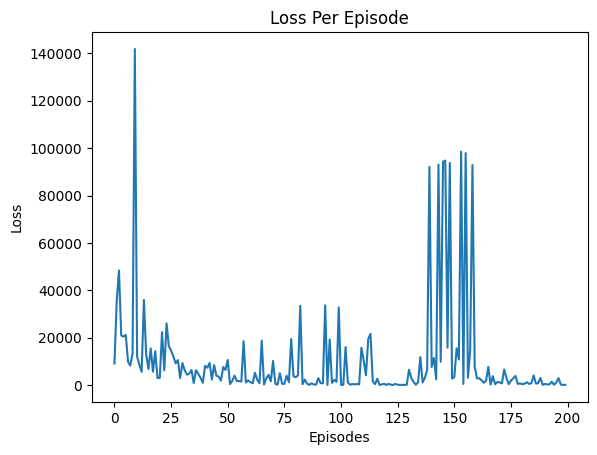

In [35]:
agent = DQNAgent(input_dim_conv, output_dim, window_size,model6, lr=0.0001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995)
log_train = train_agent(agent, states, 200, batch_size=32)
log_train.to_csv('NIFTY50/log_train_ConvGRU_200ep.csv', index=False)

Episode 1/200, Total Reward: 32.57183187591248, Loss: 9.866402564909095
Episode 2/200, Total Reward: 144.60469751925, Loss: 9.48385787724525
Episode 3/200, Total Reward: 460.0735078280174, Loss: 9.039582285747901
Episode 4/200, Total Reward: -1049.7998050000006, Loss: 9.334630144222853
Episode 5/200, Total Reward: 729.2192700779989, Loss: 9.596842504088583
Episode 6/200, Total Reward: 109.69273926314519, Loss: 9.623020857879608
Episode 7/200, Total Reward: -0.05889413388585814, Loss: 9.115202384377179
Episode 8/200, Total Reward: -111.79574802129362, Loss: 9.208746817786636
Episode 9/200, Total Reward: 181.96768157682496, Loss: 9.53087063878319
Episode 10/200, Total Reward: 0.25654858430259353, Loss: 9.31962594793412
Episode 11/200, Total Reward: 0.02171766209022484, Loss: 10.130261381411657
Episode 12/200, Total Reward: 0.005011273639516602, Loss: 9.442889473970855
Episode 13/200, Total Reward: 0.7956772598168063, Loss: 8.80991986706724
Episode 14/200, Total Reward: 559.0, Loss: 9.547

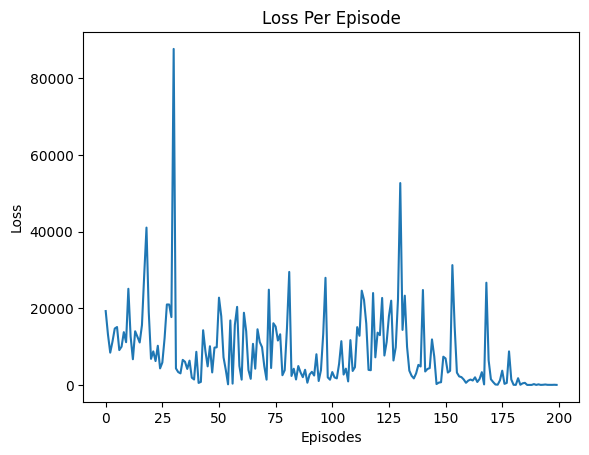

In [36]:
agent = DQNAgent(input_dim_conv, output_dim, window_size,model7, lr=0.0001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995)
log_train = train_agent(agent, states, 200, batch_size=32)
log_train.to_csv('NIFTY50/log_train_Transformer_200ep.csv', index=False)

In [ ]:
#save the model
torch.save(agent.model.state_dict(), 'NIFTY50/DQN_CNN_updated_reward_MA_800ep.pth')

### Evaluating and Testing

In [ ]:
log_train = pd.read_csv('NIFTY50/log_train_CNN_updated_reward_MA_800ep.csv')

In [21]:
log_train.rename(columns={'Reward':'Training_reward'}, inplace=True)

In [22]:
reward =[]
for i in range(1,log_train['Episode'].max()+1):
    last_episode = log_train[log_train['Episode'] == i]
    last_episode.reset_index(drop=True, inplace=True)
    last_episode['Close'] = last_episode['Price'].to_list()
    reward.append(list(capital_calculation(last_episode,'Action'))[-1]-100)

Total Pofit: 72.65033305661996
Total Pofit: 134.23775923538346
Total Pofit: 57.953628766215644
Total Pofit: 21.447916002442113
Total Pofit: 16.433631353046053
Total Pofit: -7.590674999165515
Total Pofit: 7.747091008615669
Total Pofit: 29.550550250625832
Total Pofit: -6.134633582006842
Total Pofit: 38.27345336615224
Total Pofit: 6.226554248144595
Total Pofit: -7.961892627884467
Total Pofit: -2.7378375821071046
Total Pofit: 5.304127677624734
Total Pofit: 9.29224893530862
Total Pofit: 11.56523856547922
Total Pofit: 21.437682544267943
Total Pofit: 34.01062614809999
Total Pofit: 1.21338706992222
Total Pofit: 28.324212345581742
Total Pofit: -1.7761322378331101
Total Pofit: 47.84067958225282
Total Pofit: 32.299466399042075
Total Pofit: 16.40705618598564
Total Pofit: 37.673133977704396
Total Pofit: 7.615592507638539
Total Pofit: 58.74292988232506
Total Pofit: 15.944203052711032
Total Pofit: 33.878517657915694
Total Pofit: 25.834322067838414
Total Pofit: 59.40681227336245
Total Pofit: 137.40965

In [23]:
log_train['Reward'] = log_train['Episode'].apply(lambda x: reward[x-1])

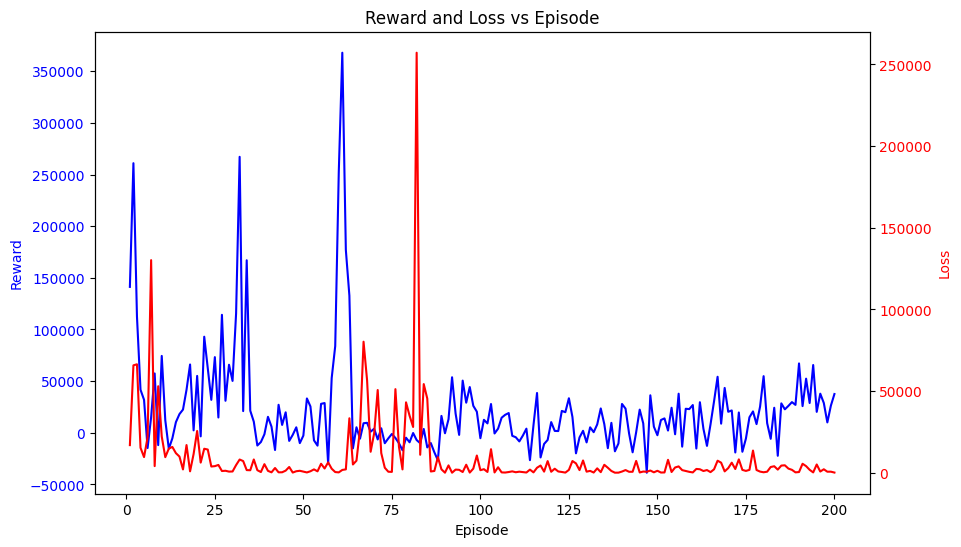

In [24]:
plot_training(log_train)

In [ ]:
log_train

In [25]:
action_episode_df = create_action_episode_df(log_train)

In [26]:
action_episode_df = action_episode_df.apply(pd.Series.value_counts).transpose().reset_index()

<Axes: >

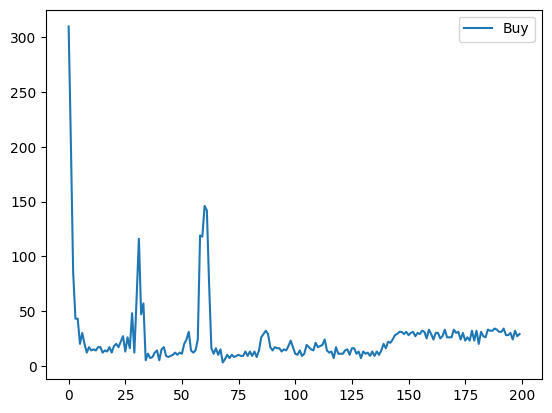

In [27]:
#get value counts of all columns in the DataFrame
action_episode_df[['Buy']].plot()

In [ ]:
# Initialize the agent
test_state_size = test_states.shape[2]
action_size = 3
model = ConvDQN(input_dim_conv, output_dim, window_size)
agent = DQNAgent(test_state_size, output_dim, window_size,model, lr=0.0001, gamma=0.95, epsilon=0, epsilon_min=0, epsilon_decay=0.9995)

In [ ]:
test_state_size

In [ ]:
model_path = 'NIFTY50/DQN_CNN_updated_reward_MA_800ep.pth'
agent.model.load_state_dict(torch.load(model_path))

# Ensure the model is in evaluation mode
agent.model.eval()

In [ ]:
evaluation_log = evaluate_agent(agent, test_states)

In [ ]:
evaluation_log['Close'] = evaluation_log['Price']
evaluation_log['Capital'] = capital_calculation(evaluation_log, 'Action')

In [ ]:
evaluation_log

In [ ]:
all_states = create_states(df_base, window_size)
all_states_eval = evaluate_agent(agent, all_states)

In [ ]:
all_states_eval['Close'] = all_states_eval['Price']
all_states_eval['Capital'] = capital_calculation(all_states_eval, 'Action')
all_states_eval

##